<a href="https://colab.research.google.com/github/lschabler/TensorFlowTutorials/blob/main/TF_ML_Tutorial6_ConvolutionalNeuralNetworksPretrained.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Deep Computer Vision **

**Convolutional Neural Network**

Each convolutional neural network is made up of one or many convolutional layers. These layers are different than the *dense* layers we have seen previously. Their goal is to find patterns from within images that can be used to classify the image or parts of it. But this may sound familiar to what our densly connected neural network in the previous section was doing, well that's becasue it is. 

The fundemental difference between a dense layer and a convolutional layer is that dense layers detect patterns globally while convolutional layers detect patterns locally. When we have a densly connected layer each node in that layer sees all the data from the previous layer. This means that this layer is looking at all the information and is only capable of analyzing the data in a global capacity. Our convolutional layer however will not be densly connected, this means it can detect local patterns using part of the input data to that layer.

**Dense Layer:** A dense layer will consider the ENTIRE image. It will look at all the pixels and use that information to generate some output.

**Convolutional Layer:** The convolutional layer will look at specific parts of the image. In this example let's say it analyzes the highlighted parts below and detects patterns there.





**Pretrained Model**

Only Change Top Layer / Fine Tune Based on Problem

https://www.tensorflow.org/tutorials/images/transfer_learning

Shuffling and writing examples to /root/tensorflow_datasets/cats_vs_dogs/4.0.0.incompleteHBZ4T1/cats_vs_dogs-train.tfrecord
Dataset cats_vs_dogs downloaded and prepared to /root/tensorflow_datasets/cats_vs_dogs/4.0.0. Subsequent calls will reuse this data.


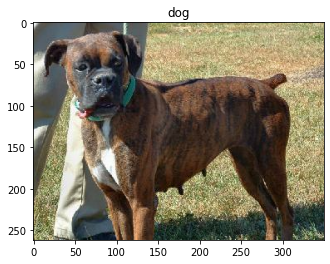

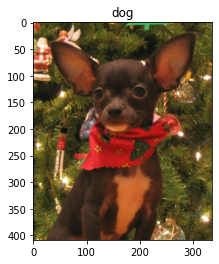

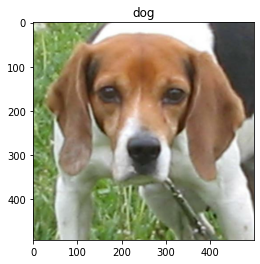

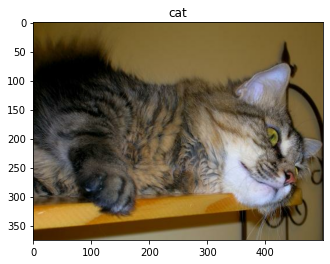

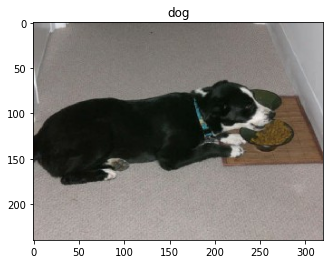

In [1]:
#Load Dataset
#Imports
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
keras = tf.keras

import tensorflow_datasets as tfds
tfds.disable_progress_bar()

# split the data manually into 80% training, 10% testing, 10% validation
(raw_train, raw_validation, raw_test), metadata = tfds.load(
    'cats_vs_dogs',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    with_info=True,
    as_supervised=True,
)

# Debug Show Images
get_label_name = metadata.features['label'].int2str  # creates a function object that we can use to get labels

# display 2 images from the dataset
for image, label in raw_train.take(5):
  plt.figure()
  plt.imshow(image)
  plt.title(get_label_name(label))

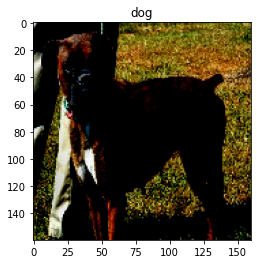

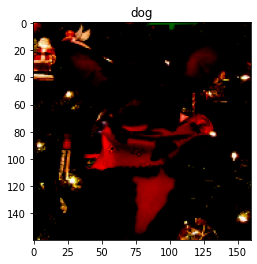

In [8]:
# Resize image

IMG_SIZE = 160 # All images will be resized to 160x160

def format_example(image, label):
  """
  returns an image that is reshaped to IMG_SIZE
  """
  image = tf.cast(image, tf.float32)
  image = (image/127.5) - 1
  image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
  return image, label

# Apply on all Image Sets
train = raw_train.map(format_example)
validation = raw_validation.map(format_example)
test = raw_test.map(format_example)

for image, label in train.take(2):
  plt.figure()
  plt.imshow(image)
  plt.title(get_label_name(label))

# Shuffle Test Data
BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 1000

train_batches = train.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
validation_batches = validation.batch(BATCH_SIZE)
test_batches = test.batch(BATCH_SIZE)

The model we are going to use as the convolutional base for our model is the MobileNet V2 developed at Google. This model is trained on 1.4 million images and has 1000 different classes.

In [10]:
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

# Create the base model from the pre-trained model MobileNet V2
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

#base_model.summary()

**Freezing the Base**

The term freezing refers to disabling the training property of a layer. It simply means we won’t make any changes to the weights of any layers that are frozen during training. This is important as we don't want to change the convolutional base that already has learned weights.

In [11]:
base_model.trainable = False
#base_model.summary()

In [12]:
# Add Classifier
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()

# 1 Dense Classification Layer
prediction_layer = keras.layers.Dense(1)

model = tf.keras.Sequential([
  base_model,
  global_average_layer,
  prediction_layer
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_160 (Functi (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 1281      
Total params: 2,259,265
Trainable params: 1,281
Non-trainable params: 2,257,984
_________________________________________________________________


In [16]:
# Training the Model

#small learning rate to ensure that the model does not have any major changes made to it.
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

initial_epochs = 3
validation_steps=20

loss0,accuracy0 = model.evaluate(validation_batches, steps = validation_steps)

20/20 [==============================] - 9s 407ms/step - loss: 0.9151 - accuracy: 0.3703


In [17]:
# Train it on cat/dog images
history = model.fit(train_batches,
                    epochs=initial_epochs,
                    validation_data=validation_batches)

acc = history.history['accuracy']
print(acc)

Epoch 1/3
582/582 [==============================] - 271s 458ms/step - loss: 0.2531 - accuracy: 0.8790 - val_loss: 0.0993 - val_accuracy: 0.9592
Epoch 2/3
582/582 [==============================] - 269s 459ms/step - loss: 0.0770 - accuracy: 0.9724 - val_loss: 0.0670 - val_accuracy: 0.9751
Epoch 3/3
582/582 [==============================] - 269s 460ms/step - loss: 0.0601 - accuracy: 0.9780 - val_loss: 0.0574 - val_accuracy: 0.9781
[0.8789898157119751, 0.9723804593086243, 0.9779688119888306]


In [18]:
loss0,accuracy0 = model.evaluate(validation_batches, steps = validation_steps)

20/20 [==============================] - 8s 414ms/step - loss: 0.0629 - accuracy: 0.9750


In [24]:

predictions = model.predict(test_batches)

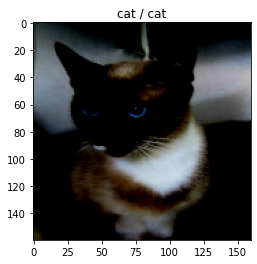

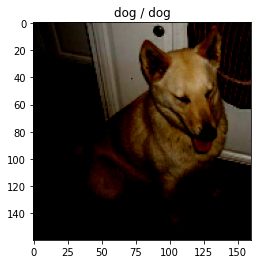

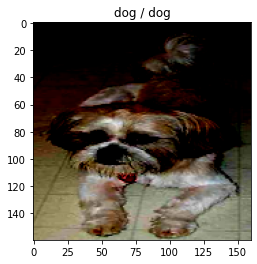

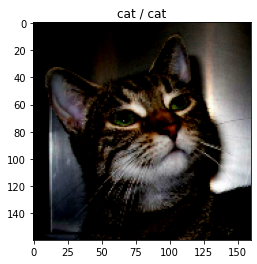

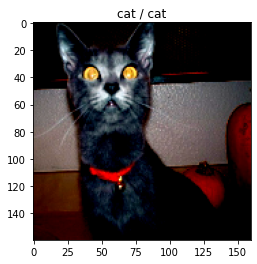

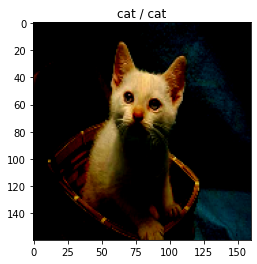

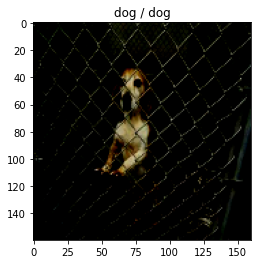

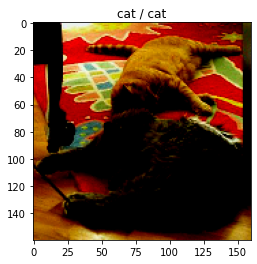

In [53]:
# cat - 1 | dog 1


index = 0
for image, label in test.take(8):
  plt.figure()
  plt.imshow(image)
  pred_label = "cat"
  if predictions[index] > 0:
    pred_label = "dog"
  plt.title(get_label_name(label) + " / " + pred_label)
  index+=1

In [ ]:
# Save and Load Moder
#model.save("dogs_vs_cats.h5") 
#new_model = tf.keras.models.load_model('dogs_vs_cats.h5')